<a href="https://colab.research.google.com/github/SalhaAlzahrani/MS_Trust/blob/main/MS_Trust_DualAtten_MY_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Myelitis Classification using Compact Convolutional Transformers --> Improved with Attention Mechanisms






In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio
!pip install keras-cv tensorflow --upgrade

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras_cv

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import numpy as np
from google.colab import drive
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight

# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

Mounted at /content/drive


# 🈺 Hyperparameters



In [ ]:
######################
NUM_CLASSES = 3
######################
positional_emb = True
conv_layers = 2
projection_dim = 128
num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1
learning_rate = 0.001
weight_decay = 0.0001
NUM_EPOCHS = 100
IMG_SIZE =224
BATCH_SIZE = 32
input_shape = (IMG_SIZE, IMG_SIZE, 3)
np.random.seed(42)
tf.random.set_seed(42)
AUTO = tf.data.AUTOTUNE

In [ ]:
def preprocess_image(path):
    image = tf.keras.utils.load_img(path)
    image = tf.image.central_crop(image, central_fraction=0.9)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image

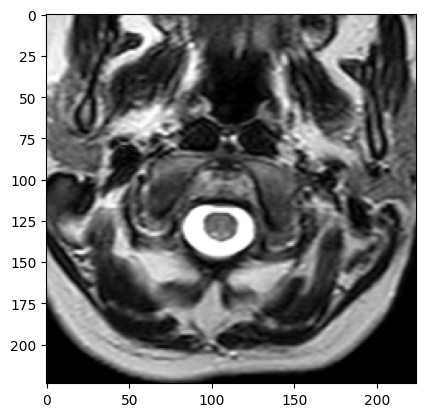

In [ ]:
plt.imshow(preprocess_image(os.path.join("/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/myelitis/", "1 (1).jpg" )))

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])
    epochs = range(len(history.history['loss']))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.')
    ax1.plot(epochs, val_loss, label='val_loss', marker='.')
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.legend();


---
# 🧠 Load Myelitis Dataset




In [ ]:
path = '/content/drive/MyDrive/Myelitis_Dataset_Three_Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 2771 files belonging to 3 classes.
Using 2217 files for training.
Found 2771 files belonging to 3 classes.
Using 554 files for validation.


In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 2771 files belonging to 3 classes.


{0: 0.6607057701478303, 1: 1.384807596201899, 2: 1.3083097261567516}

# 🅰 Data augmentation



In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix(alpha=0.02)
randaug = keras_cv.layers.RandAugment(value_range=(0, 255), augmentations_per_image=3, magnitude=0.5)

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

In [ ]:
def aug_pipeline1(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = cutmix(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = randaug(samples, training=True)
    return samples

#RandAug
randaug_ds = train_ds.shuffle(1000).map(to_dict)
randaug_ds = randaug_ds.map(aug_pipeline3)
randaug_ds = randaug_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
randaug_ds = randaug_ds.prefetch(AUTOTUNE) #Use this for fit
#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline1)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit
#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline2)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit




---


## ⛓ The CCT tokenizer

The first recipe introduced by the CCT authors is the tokenizer for processing the images. In a standard ViT, images are organized into uniform non-overlapping patches. This eliminates the boundary-level information present in between different patches. This is important for a neural network to effectively exploit the locality information. The figure below presents an illustration of how images are organized into patches.

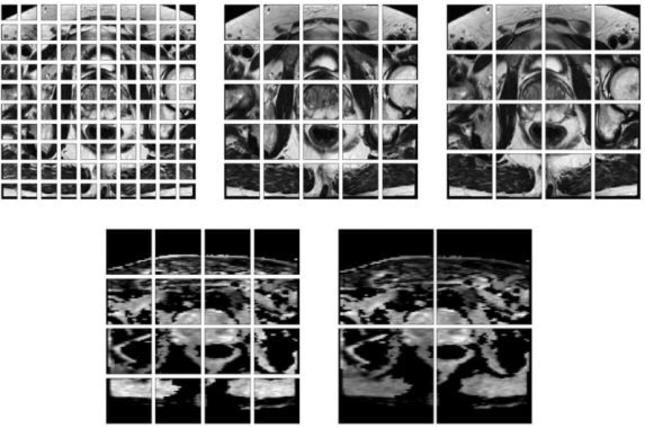

We already know that convolutions are quite good at exploiting locality information. So, based on this, the authors introduce an all-convolution mini-network to produce image patches.

In [ ]:
#https://keras.io/examples/vision/cct/
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)
        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )
        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]
            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

## Stochastic depth for regularization

Stochastic depth is a regularization technique that randomly drops a set of layers. During inference, the layers are kept as they are. It is very much similar to Dropout but only that it operates on a block of layers rather than individual nodes present inside a layer. In CCT, stochastic depth is used just before the residual blocks of a Transformers encoder.

In [ ]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop
    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

## MLP for the Transformers encoder


In [ ]:
class SqueezeExcite(layers.Layer):
    """Applies squeeze and excitation to input feature maps as seen in https://arxiv.org/abs/1709.01507.
    Args:         ratio: The ratio with which the feature map needs to be reduced in the reduction phase.
    Inputs:         Convolutional features.
    Outputs:        Attention modified feature maps.
    """
    def __init__(self, ratio, **kwargs):
        super().__init__(**kwargs)
        self.ratio = ratio
    def get_config(self):
        config = super().get_config()
        config.update({"ratio": self.ratio})
        return config
    def build(self, input_shape):
        filters = input_shape[-1]
        self.squeeze = layers.GlobalAveragePooling2D(keepdims=True)
        self.reduction = layers.Dense(
            units=filters // self.ratio, activation="relu", use_bias=False,
        )
        self.excite = layers.Dense(units=filters, activation="sigmoid", use_bias=False)
        self.multiply = layers.Multiply()
    def call(self, x):
        shortcut = x
        x = self.squeeze(x)
        x = self.reduction(x)
        x = self.excite(x)
        x = self.multiply([shortcut, x])
        return x
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        SqueezeExcite(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Attention layers

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
  """
  Base Attention layer class that contains a MultiHeadAttention, LayerNormalization and Add layer.
  """
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
  """
  A class that implements cross-attention mechanism by inheriting from BaseAttention class.
  Cross-attention is used to process two different sequences and attends to the context sequence while processing the query sequence.
  """
  def call(self, x, context):
    """
    The call function that performs the cross-attention operation.
    Args:
        x: The query sequence tensor, shape=(batch_size, seq_len, embedding_dim)
        context: The context sequence tensor, shape=(batch_size, seq_len, embedding_dim)
    Returns:
        The attended output tensor, shape=(batch_size, seq_len, embedding_dim)
    """
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    """
    Apply the global self-attention mechanism to the input sequence.
    Args:
        x: A tensor of shape `(batch_size, seq_len, embedding_dim)`
        representing the input sequence.
    Returns:
        A tensor of the same shape as the input, representing the sequence
        after being transformed by the self-attention mechanism.
    """
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

class CausalSelfAttention(BaseAttention):
  """
  Call self attention on the input sequence, ensuring that each position in the
  output depends only on previous positions (i.e. a causal model).
  Args:
      x: Input sequence tensor of shape `(batch_size, seq_len, embed_dim)`.
  Returns:
      Output sequence tensor of the same shape as the input, after self-attention
      and residual connection with layer normalization applied.
  """
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

## The final model



In [ ]:
def create_cct_model(
    image_size=IMG_SIZE,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(inputs)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        ###############################################################################
        # Layer normalization 1.
        x11 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
        # CausalSelfAttention
        attention_output = CausalSelfAttention(num_heads=num_heads, key_dim=projection_dim)(x11)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

        ###############################################################################
        # Layer normalization 1.
        x12 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
        # GlobalSelfAttention
        attention_output = GlobalSelfAttention(num_heads=num_heads, key_dim=projection_dim)(x12)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

        ###############################################################################
        # CrossAttention
        attention_output = CrossAttention(num_heads=num_heads, key_dim=projection_dim)(x11, x12)
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES , activation="softmax")(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model = create_cct_model()
#model.summary()



---


# 🧠 Myelitis Classification: MixUp & Proposed Method






## Visualize the new augmented dataset

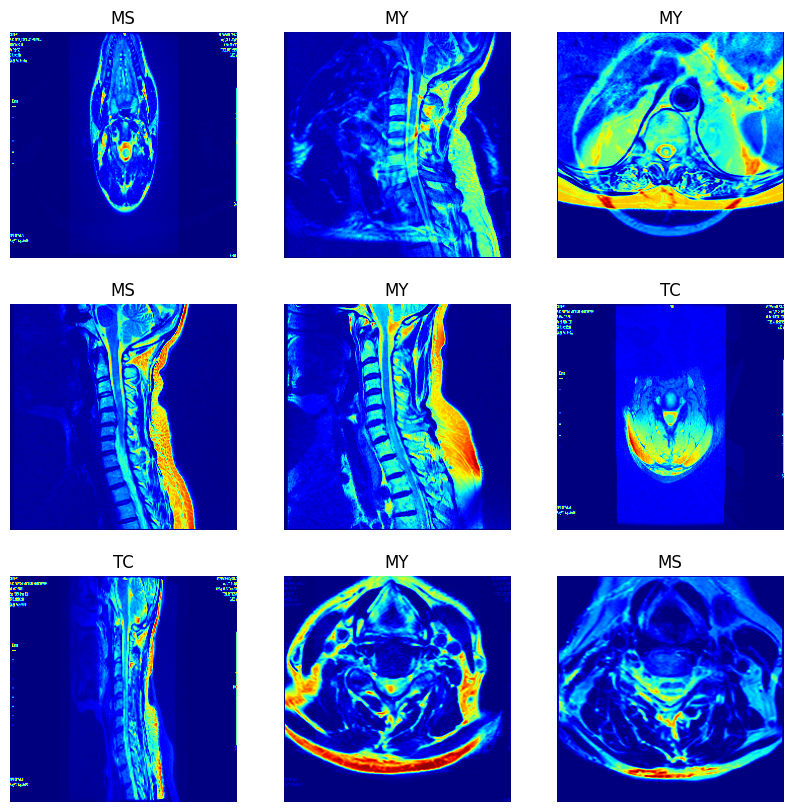

In [ ]:
for images, labels in mixup_ds.take(1):
  plt.figure(figsize=(10, 10))
  for i in range (0,9):
    img = images[i]
    lbl = np.argmax(labels[i])
    if lbl == 0: label="TC"
    elif lbl == 1: label="MS"
    else: label="MY"
    ax = plt.subplot(3, 3, i+1)
    plt.title(label)
    plt.imshow(tf.image.rgb_to_grayscale(img), cmap='jet')
    #plt.imshow(img)
    plt.axis('off')

## Model training and evaluation


In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)
model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
        ],
    )
history = model.fit(mixup_ds,
                    validation_data=val_ds_v,
                    batch_size=BATCH_SIZE,
                    class_weight=class_weights_dict,
                    epochs=NUM_EPOCHS)

Epoch 1/100
70/70 [==============================] - 50s 518ms/step - loss: 0.9006 - accuracy: 0.7059 - precision: 0.8530 - recall: 0.4455 - auc: 0.7471 - f1_score: 0.6123 - val_loss: 0.6375 - val_accuracy: 0.7870 - val_precision: 0.8130 - val_recall: 0.7690 - val_auc: 0.9324 - val_f1_score: 0.6937
Epoch 2/100
70/70 [==============================] - 37s 496ms/step - loss: 0.7409 - accuracy: 0.7799 - precision: 0.8889 - recall: 0.4946 - auc: 0.7991 - f1_score: 0.6774 - val_loss: 0.6664 - val_accuracy: 0.7780 - val_precision: 0.7865 - val_recall: 0.7581 - val_auc: 0.9214 - val_f1_score: 0.6933
Epoch 3/100
70/70 [==============================] - 37s 489ms/step - loss: 0.7484 - accuracy: 0.7916 - precision: 0.8761 - recall: 0.5050 - auc: 0.7877 - f1_score: 0.6989 - val_loss: 0.5888 - val_accuracy: 0.8069 - val_precision: 0.8327 - val_recall: 0.7635 - val_auc: 0.9503 - val_f1_score: 0.6649
Epoch 4/100
70/70 [==============================] - 37s 491ms/step - loss: 0.7373 - accuracy: 0.797

## Let's visualize the training progress of the model.


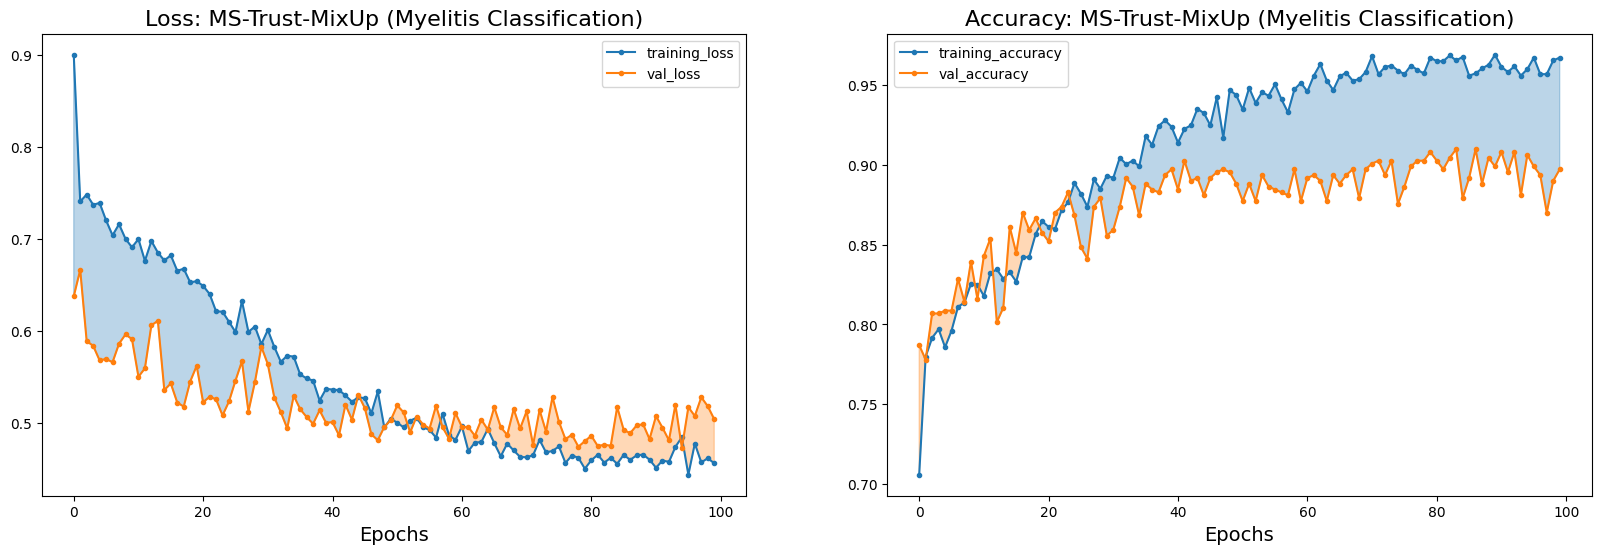

In [ ]:
plot_training_curves(history, 'MS-Trust-MixUp (Myelitis Classification)')



---


# 🧠 Myelitis Classification: CutMix & Proposed Method






## Visualize the new augmented dataset

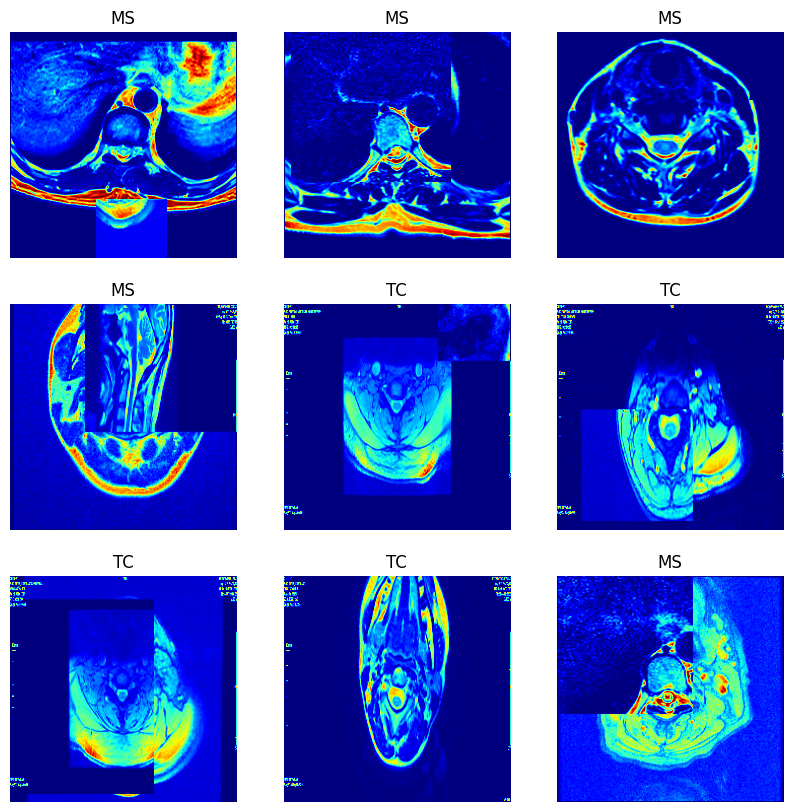

In [ ]:
for images, labels in cutmix_ds.take(1):
  plt.figure(figsize=(10, 10))
  for i in range (0,9):
    img = images[i]
    lbl = np.argmax(labels[i])
    if lbl == 0: label="TC"
    else: label="MS"
    ax = plt.subplot(3, 3, i+1)
    plt.title(label)
    plt.imshow(tf.image.rgb_to_grayscale(img), cmap='jet')
    #plt.imshow(img)
    plt.axis('off')

## Model training and evaluation


In [ ]:
model = create_cct_model()
#model.summary()

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
        ],
    )
history = model.fit(cutmix_ds,
                    validation_data=val_ds_v,
                    batch_size=BATCH_SIZE,
                    class_weight=class_weights_dict,
                    epochs=NUM_EPOCHS)

Epoch 1/100
70/70 [==============================] - 257s 1s/step - loss: 0.9820 - accuracy: 0.6238 - precision: 0.7300 - recall: 0.4198 - auc: 0.7650 - f1_score: 0.4932 - val_loss: 0.6255 - val_accuracy: 0.7744 - val_precision: 0.8004 - val_recall: 0.7238 - val_auc: 0.9388 - val_f1_score: 0.6743
Epoch 2/100
70/70 [==============================] - 37s 486ms/step - loss: 0.8830 - accuracy: 0.6739 - precision: 0.7708 - recall: 0.5341 - auc: 0.8286 - f1_score: 0.5852 - val_loss: 0.6132 - val_accuracy: 0.8032 - val_precision: 0.8212 - val_recall: 0.7708 - val_auc: 0.9453 - val_f1_score: 0.7222
Epoch 3/100
70/70 [==============================] - 37s 492ms/step - loss: 0.8325 - accuracy: 0.6861 - precision: 0.7904 - recall: 0.5593 - auc: 0.8531 - f1_score: 0.6062 - val_loss: 0.6020 - val_accuracy: 0.8051 - val_precision: 0.8311 - val_recall: 0.7816 - val_auc: 0.9476 - val_f1_score: 0.7398
Epoch 4/100
70/70 [==============================] - 37s 496ms/step - loss: 0.8053 - accuracy: 0.7131 

## Let's visualize the training progress of the model.


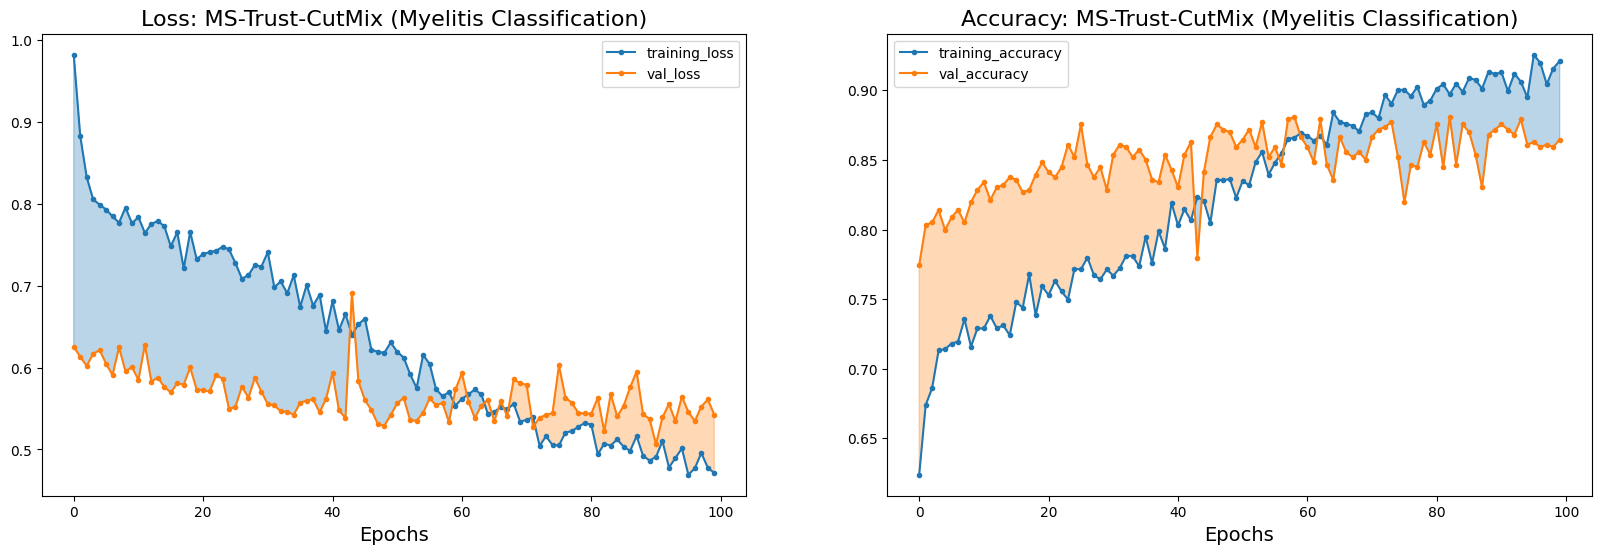

In [ ]:
plot_training_curves(history, 'MS-Trust-CutMix (Myelitis Classification)')



---
# ⚓ RandAug


## Model training and evaluation


In [ ]:
model = create_cct_model()
#model.summary()

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.AUC(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average='macro', threshold=0.5),
        ],
    )
history = model.fit(randaug_ds,
                    validation_data=val_ds_v,
                    batch_size=BATCH_SIZE,
                    class_weight=class_weights_dict,
                    epochs=50)

Epoch 1/50
70/70 [==============================] - 133s 716ms/step - loss: 0.9680 - accuracy: 0.5846 - precision: 0.6829 - recall: 0.3915 - auc: 0.7712 - f1_score: 0.4445 - val_loss: 0.6125 - val_accuracy: 0.7852 - val_precision: 0.7992 - val_recall: 0.7617 - val_auc: 0.9423 - val_f1_score: 0.6925
Epoch 2/50
70/70 [==============================] - 37s 489ms/step - loss: 0.8592 - accuracy: 0.6793 - precision: 0.7566 - recall: 0.5399 - auc: 0.8553 - f1_score: 0.5627 - val_loss: 0.6457 - val_accuracy: 0.7834 - val_precision: 0.7955 - val_recall: 0.7726 - val_auc: 0.9301 - val_f1_score: 0.7169
Epoch 3/50
70/70 [==============================] - 36s 479ms/step - loss: 0.8416 - accuracy: 0.6924 - precision: 0.7510 - recall: 0.5945 - auc: 0.8645 - f1_score: 0.6128 - val_loss: 0.6415 - val_accuracy: 0.7996 - val_precision: 0.8482 - val_recall: 0.7365 - val_auc: 0.9354 - val_f1_score: 0.7088
Epoch 4/50
70/70 [==============================] - 35s 465ms/step - loss: 0.8329 - accuracy: 0.7037 -

## Let's visualize the training progress of the model.


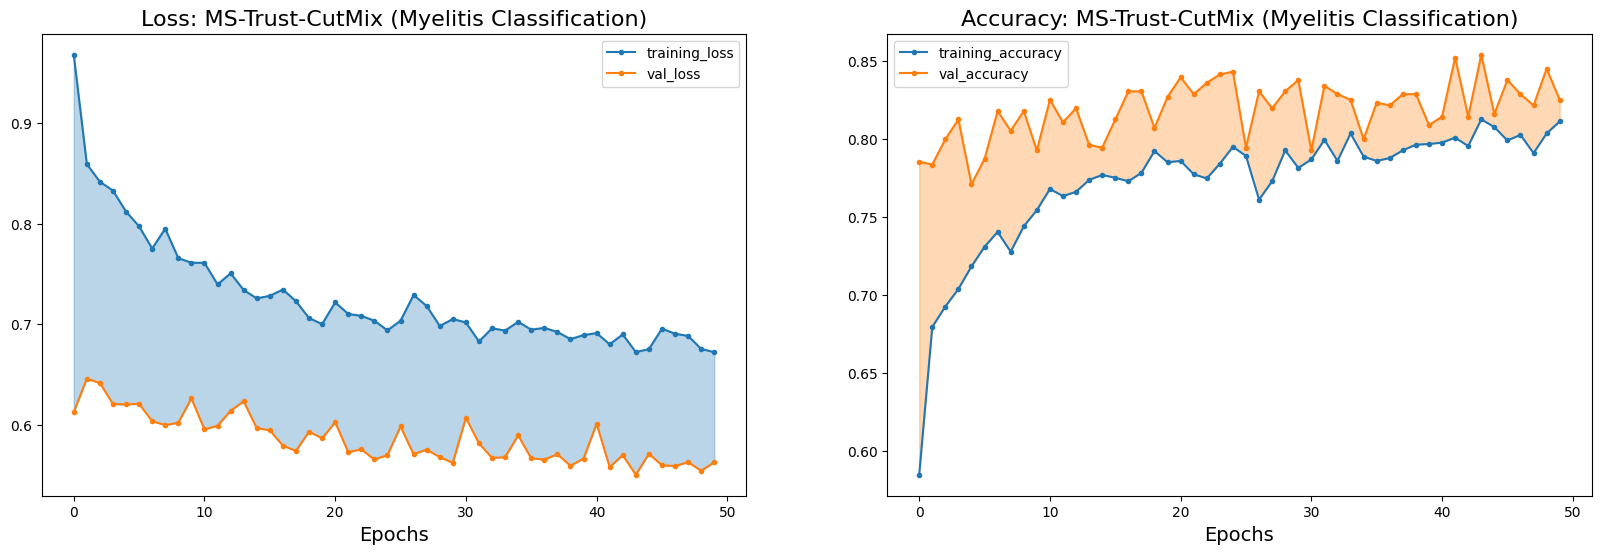

In [ ]:
plot_training_curves(history, 'MS-Trust-CutMix (Myelitis Classification)')